In [3]:
%load_ext autoreload
%autoreload 2
import os
import json
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

from src.grid import Grid
from src.graphics import display_grid
from src.agent import Agent
import src.testgrid_constants as constants
import src.neural_net
from src.utils import generate_array, in_bounds

In [31]:
easy1 = {'train':(1,0),'trainvel':(0,1),'cargo1':(3,2),'num1':1,'target1':(2,2), 'switch':(0,0),'agent':(4,2),'cargo2':(2,4),'num2':2,'target2':(0,3)}
push3 = {"train": (0, 3), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (0, 4), "switch": (2, 4), "agent": (2, 0), "cargo2": (3, 3), "target2": (3, 4),'num1':1, "num2":2}
push12 = {"train": (1, 0), "trainvel": (0, 1), "cargo1": (2, 2), "target1": (3, 1), "switch": (0, 4), "agent": (3, 1), "cargo2": (1, 4), "target2": (0, 3), 'num1':1, 'num2':2}
push14 = {"train": (4, 4), "trainvel": (-1, 0), "cargo1": (1, 3), "target1": (3, 2), "switch": (4, 1), "agent": (0, 2), "cargo2": (0, 4), "target2": (0, 1), 'num1':1, 'num2':2}
swit27 = {"train": (1, 0), "trainvel": (0, 1), "cargo1": (0, 1), "target1": (4, 3), "switch": (3, 3), "agent": (4, 4), "cargo2": (1, 2), "target2": (0, 3), 'num1':1, "num2":2}
swit10 = {"train": (0, 2), "trainvel": (1, 0), "cargo1": (2, 2), "target1": (2, 3), "switch": (4, 0), "agent": (2, 0), "cargo2": (1, 3), "target2": (4, 2), 'num1':1, "num2":2} 
reallyhard45 = {"train": (4, 0), "trainvel": (0, 1), "cargo1": (1, 4), "target1": (2, 3), "switch": (3, 0), "agent": (3, 2), "cargo2": (4, 3), "target2": (3, 3), 'num1':1, "num2":2}

In [60]:
testgrid = Grid(5, random=False, init_pos=reallyhard45)
display_grid(testgrid)

[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '_' '◉' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' 'S' '^']]
=====


array([['_', '1', '_', '_', '_'],
       ['_', '_', 'a', 'b', '2'],
       ['_', '_', '_', '◉', '_'],
       ['_', '_', '_', '_', '_'],
       ['_', '_', '_', 'S', '^']], dtype='<U1')

In [33]:
agent=Agent()
Q, policy = agent.mc_first_visit_control(testgrid, iters=10000, nn_init=True)
grids,actions,r = agent.run_final_policy(testgrid, Q,nn_init=True,display=True)

neural net loaded
[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '_' '◉' '_']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' 'S' '^']]
=====
(1, 0)
[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '_' '_' '_']
 ['_' '_' '_' '◉' '^']
 ['_' '_' '_' 'S' '_']]
=====
(0, 0)
[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '_' '_' '^']
 ['_' '_' '_' '◉' '_']
 ['_' '_' '_' 'S' '_']]
=====
(1, 0)
[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '_' '<' '_']
 ['_' '_' '_' '◉' '_']
 ['_' '_' '_' 'S' '_']]
=====
(0, 0)
[['_' '1' '_' '_' '_']
 ['_' '_' 'a' 'b' '2']
 ['_' '_' '<' '_' '_']
 ['_' '_' '_' '◉' '_']
 ['_' '_' '_' 'S' '_']]
=====
(0, 0)
0


In [62]:
def run_both(testgrid,iterlist,num):
    dual = [0]*len(iterlist)
    based = [0]*len(iterlist)
    agent = Agent()

    for idx,iters in enumerate(iterlist):
        for i in range(num):
            Q, policy = agent.mc_first_visit_control(testgrid, iters=iters, nn_init=True)
            grids,actions,r = agent.run_final_policy(testgrid.copy(), Q,nn_init=True,display=False)
            dual[idx] += r

            Q, policy = agent.mc_first_visit_control(testgrid, iters=iters, nn_init=False)
            grids,actions,r = agent.run_final_policy(testgrid.copy(), Q,nn_init=False,display=False)
            based[idx] += r


    dual = [x/num for x in dual]
    based = [x/num for x in based]
    return dual,based

dual,based = run_both(testgrid,[0,100,200,300,400,500],1)
print(dual,based)

neural net loaded
[-4.0, 0.0, -2.0, -2.0, -2.0, 0.0] [-2.0, -2.0, 0.0, 0.0, 0.0, -2.0]


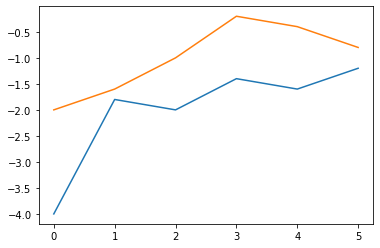

In [58]:
plt.plot(dual, label = "dual")
plt.plot(based, label = "based")

In [147]:
with open('gridworld_experiment/test_data.json') as json_file:
    json_data = json.load(json_file)
   
push_dilemma = []
switch_dilemma = []
push_get = []
switch_save = []

for key,grid in json_data.items():
    for pos in json_data[key]:
        if type(json_data[key][pos])==list: 
            json_data[key][pos] = tuple(json_data[key][pos])
    json_data[key]['num1'] = 1
    json_data[key]['num2'] = 2
    grid = Grid(init_pos=json_data[key])
    print(try_all(grid))
    if 100 <= int(key) <= 108:
        rewards = try_all(grid)
        push_dilemma.append(rewards[-1]/3125*100)
    if 200 <= int(key) <= 208:
        rewards = try_all(grid)
        switch_dilemma.append(rewards[-1]/3125*100)
    if 300 <= int(key) <= 308:
        rewards = try_all(grid)
        switch_save.append(rewards[0]/3125*100)
    if 400 <= int(key) <= 408:
        rewards = try_all(grid)
        push_get.append(rewards[1]/3125*100)

    #print(run_both(grid,[0,20,30,50,100],10))
       

defaultdict(<class 'int'>, {0: 2204, -4: 920, 1: 1})
defaultdict(<class 'int'>, {-4: 740, 0: 260, -2: 2125})
defaultdict(<class 'int'>, {0: 2418, -4: 590, -2: 65, 2: 41, 1: 11})
defaultdict(<class 'int'>, {0: 3067, -4: 40, 2: 18})
defaultdict(<class 'int'>, {-1: 3125})
defaultdict(<class 'int'>, {0: 2883, -4: 230, 2: 12})
defaultdict(<class 'int'>, {-2: 1500, -4: 970, 0: 655})
defaultdict(<class 'int'>, {-2: 2432, -1: 63, 0: 619, 1: 11})
defaultdict(<class 'int'>, {-1: 2375, -4: 440, 0: 178, 1: 132})
defaultdict(<class 'int'>, {-2: 140, 0: 2972, 2: 13})
defaultdict(<class 'int'>, {-1: 3125})
defaultdict(<class 'int'>, {-3: 690, 1: 179, 0: 6, -1: 2250})
defaultdict(<class 'int'>, {-2: 2504, 0: 621})
defaultdict(<class 'int'>, {-2: 2500, -4: 565, 0: 60})
defaultdict(<class 'int'>, {-1: 2825, -4: 265, 0: 35})
defaultdict(<class 'int'>, {-4: 60, 0: 2896, -1: 91, -2: 3, 2: 75})
defaultdict(<class 'int'>, {0: 3112, 2: 13})
defaultdict(<class 'int'>, {-2: 2630, -1: 96, 0: 281, -4: 118})
defau

In [4]:
print("push_dilemma",push_dilemma)
print("switch_dilemma", switch_dilemma)
print("switch_save", switch_save)
print("push_get",push_get)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

x = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 2000)
bins = np.linspace(0, 100, 30)

plt.hist([push_dilemma, switch_dilemma,switch_save,push_get], bins, label=['push_dilemma', 'switch_dilemma',"switch_save","push_get"])
plt.legend(loc='upper right')
plt.show()

print("MEANS")
print("push_dilemma",np.mean(push_dilemma))
print("switch_dilemma",np.mean(switch_dilemma))
print("switch_save",np.mean(switch_save))
print("push_get",np.mean(push_get))

NameError: name 'push_dilemma' is not defined

In [77]:
from collections import defaultdict

actions = [(-1,0),(0,-1),(1,0),(0,1),(0,0)]
all_possible = []
for i in range(5):
    for j in range(5):
        for k in range(5):
            for l in range(5):
                for m in range(5):
                    all_possible.append([actions[i],actions[j],actions[k],actions[l],actions[m]])

def try_all(grid):
    reward_dict = defaultdict(int)
    for policy in all_possible:
        g = grid.copy()
        r = 0
        for action in policy:
            r += g.R(action)
            g.T(action)
        reward_dict[r] += 1
    return reward_dict


In [37]:
ITERS = [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400] #[0,200,400,600,800,1000,1200]
REPEATS = 20 #number of times to redo the iteration; for consistency

def run_mc_sim():
    agent = Agent()
    dual_scores = defaultdict(list)
    mc_scores = defaultdict(list)
    for gridnum, grid in constants.TEST_GRIDS.items():
        print(gridnum)
        best_reward = grid['best_reward']
        for i in ITERS:
            dual_score = 0
            mc_score = 0
            for j in range(REPEATS):
                testgrid = Grid(5,random=False, init_pos=grid)
                Q, policy = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
                _, _, reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
                dual_score += reward - best_reward 
                
                testgrid = Grid(5,random=False, init_pos=grid)
                Q, policy = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=False)
                _, _, reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=False)
                mc_score += reward - best_reward 
            dual_avg = dual_score/REPEATS
            mc_avg = mc_score/REPEATS
            dual_scores[gridnum].append(dual_avg)
            mc_scores[gridnum].append(mc_avg)
    
    return dual_scores, mc_scores

def exclude_grids(dual_scores,mc_scores):
    dual_type_dict = defaultdict(list)
    mc_type_dict = defaultdict(list)

    for grid, scores in dual_scores.items():
        #if grid not in [401,405,204,208]:
        dual_type_dict[grid//100*100].append(scores)
        mc_type_dict[grid//100*100].append(mc_scores[grid])
    
    for k,v in dual_type_dict.items():
        v = np.array(v)
        size = v.shape[0]
        dual_type_dict[k] = np.sum(v,axis=0)/size
        
        v = np.array(mc_type_dict[k])
        mc_type_dict[k] = np.sum(v,axis=0)/size
    return mc_type_dict, dual_type_dict
   
def graph_results(mc_type_dict, dual_type_dict):
    plt.plot(ITERS, dual_type_dict[100], label='push sacrifice', color="blue")
    plt.plot(ITERS, dual_type_dict[200], label='switch sacrifice', color="green")
    plt.plot(ITERS, dual_type_dict[300], label='switch save', color="orange")
    plt.plot(ITERS, dual_type_dict[400], label='push get', color="brown")
    plt.legend()
    plt.xlabel("Number of MC Iterations")
    plt.ylabel("Normalized Score")
    plt.title("Dual model performance on all test grids")
    plt.show()

    plt.plot(ITERS, mc_type_dict[100], label='push sacrifice', color="blue")
    plt.plot(ITERS, mc_type_dict[200], label='switch sacrifice', color="green")
    plt.plot(ITERS, mc_type_dict[300], label='switch save', color="orange")
    plt.plot(ITERS, mc_type_dict[400], label='push get', color="brown")
    plt.legend()
    plt.xlabel("Number of MC Iterations")
    plt.ylabel("Normalized Score")
    plt.title("MC model performance on all test grids")
    plt.show()


In [38]:
dual_scores, mc_scores = run_mc_sim()
print(dual_scores,mc_scores)

101
neural net loaded
102
103
104
105
106
107
108
201
202
203
204
205
206
207
208
301
302
303
304
305
306
307
308
401
402
403
404
405
406
407
408
defaultdict(<class 'list'>, {101: [-1.0, -0.7, -0.6, -0.65, -0.25, -0.3, -0.15, 0.0, -0.05, 0.0, 0.0, 0.0, -0.05, -0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 102: [-1.0, -0.95, -0.8, -0.65, -0.75, -0.45, -0.25, -0.2, -0.1, -0.15, -0.1, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 103: [-1.0, -1.0, -0.95, -1.0, -0.95, -1.0, -0.95, -0.85, -0.8, -0.95, -1.0, -0.9, -0.8, -0.9, -0.85, -0.9, -0.85, -0.85, -0.8, -0.85, -0.9], 104: [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 105: [0.0, -0.05, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 106: [-1.0, -0.9, -1.0, -0.65, -0.45, -0.35, -0.25, -0.15, -0.05, -0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 107: [-1.0, -1.0, -0.85, -0.8, -0.65, -0.45, -0.35, -0.5, -0.1, -0.2

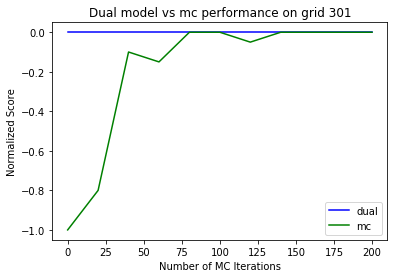

In [269]:
def graph_one(num, dual_scores, mc_scores):
    plt.plot(ITERS, dual_scores[num], label='dual', color="blue")
    plt.plot(ITERS, mc_scores[num], label='mc', color="green")
    plt.legend()
    plt.xlabel("Number of MC Iterations")
    plt.ylabel("Normalized Score")
    plt.title("Dual model vs mc performance on grid " + str(num))
    plt.show()

graph_one(301,dual_scores,mc_scores)

defaultdict(<class 'list'>, {100: [[0.0, -0.7, -0.6, -0.65, -0.25, -0.3, -0.15, 0.0, -0.05, 0.0, 0.0, 0.0, -0.05, -0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -0.5499999999999999, -0.8, -0.6, -0.7, -0.4, -0.25, -0.2, -0.1, -0.15, -0.1, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -0.050000000000000044, -0.5499999999999999, -0.65, -0.6499999999999999, -0.75, -0.8999999999999999, -0.7999999999999999, -0.75, -0.75, -0.9, -0.9, -0.75, -0.9, -0.85, -0.9, -0.85, -0.85, -0.8, -0.85, -0.9], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.35000000000000003, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -0.30000000000000004, -1.0, -0.65, -0.45, -0.35, -0.25, -0.15, -0.05, -0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -0.44999999999999996, -0.85, -0.8, -0.65, -0.45, -0.35, -0.5, -0.1, -0.25, -0.05, 0.0, -0.05, 0.0, 0.0, 0.0, -0.05, 0.0

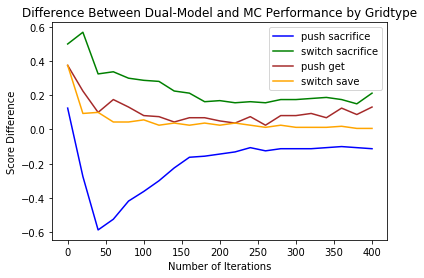

In [42]:
grid_score_diff = defaultdict(list)

for grid, scores in dual_scores.items():
    difference = []
    zip_obj = zip(scores, mc_scores[grid])
    for dual_score, mc_score in zip_obj:
        difference.append(dual_score - mc_score)
    grid_score_diff[grid//100*100].append(difference)
print(grid_score_diff)   
 
for k,v in grid_score_diff.items():
    v = np.array(v)
    size = v.shape[0]
    grid_score_diff[k] = np.sum(v,axis=0)/size
        
print(grid_score_diff)

plt.plot(ITERS, grid_score_diff[100], label='push sacrifice', color="blue")
plt.plot(ITERS, grid_score_diff[200], label='switch sacrifice', color="green")
plt.plot(ITERS, grid_score_diff[400], label='push get', color="brown")
plt.plot(ITERS, grid_score_diff[300], label='switch save', color="orange")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Score Difference")
plt.title("Difference Between Dual-Model and MC Performance by Gridtype")
plt.show()

In [43]:
mc_type_dict, dual_type_dict = exclude_grids(dual_scores, mc_scores)
print(mc_type_dict, dual_type_dict)

defaultdict(<class 'list'>, {100: array([-1.     , -0.4125 , -0.05625, -0.05625, -0.04375, -0.0375 ,
       -0.00625, -0.00625, -0.00625, -0.025  , -0.0125 ,  0.     ,
       -0.00625,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ]), 200: array([-1.     , -0.7625 , -0.4875 , -0.45   , -0.3625 , -0.3625 ,
       -0.31875, -0.2625 , -0.25   , -0.20625, -0.2    , -0.21875,
       -0.2125 , -0.19375, -0.2    , -0.2    , -0.2125 , -0.20625,
       -0.2    , -0.19375, -0.2125 ]), 300: array([-1.     , -0.1125 , -0.10625, -0.04375, -0.04375, -0.05625,
       -0.025  , -0.0375 , -0.025  , -0.0375 , -0.025  , -0.0375 ,
       -0.025  , -0.0125 , -0.025  , -0.0125 , -0.0125 , -0.0125 ,
       -0.01875, -0.00625, -0.00625]), 400: array([-1.     , -0.53125, -0.39375, -0.4125 , -0.35625, -0.31875,
       -0.29375, -0.25625, -0.26875, -0.24375, -0.225  , -0.21875,
       -0.24375, -0.2    , -0.24375, -0.21875, -0.20625, -0.2125 ,
       -0.25   , -0.19375, -0.

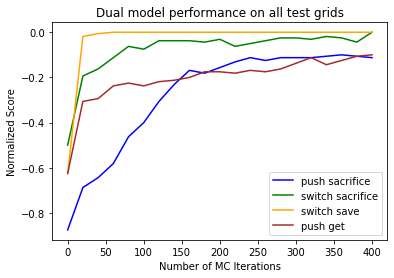

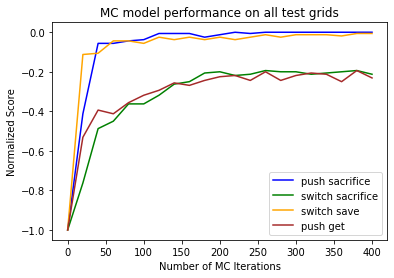

In [44]:
graph_results(mc_type_dict,dual_type_dict)

In [256]:
testgrid = Grid(5, random=False, init_pos=constants.TEST_GRIDS[305])
agent = Agent()
Q, policy = agent.mc_first_visit_control(testgrid.copy(), iters=10, nn_init=False, softmax=True)
a, b, reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=True)


[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, -1.0, 0] [0.22894405 0.22894405 0.22894405 0.08422381 0.22894405]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, -1.0, -1.0, 0] [0.26768323 0.26768323 0.09847516 0.09847516 0.26768323]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0.0, 0] [0.2 0.2 0.2 0.2 0.2]
[-1.0, 0, -1.0, -1.0, 0] [0.11853167 0.32220249 0.11853167 0.11853167 0.32220249]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[0, 0, 0, 0, 0] [0.2 0.2 0.2 0.2 0.2]
[-1.0, 0.0, -1.0, -1.0, 0] [0.11853167 0.32220249 0.11853167 0.11853167 0.32220249]
[0.0, 0, 0, 0, 0] [0.2 0.2 0.2 

Text(0.5, 1.0, 'Action Value Z-Scores for Pushing/Switching by Gridtype')

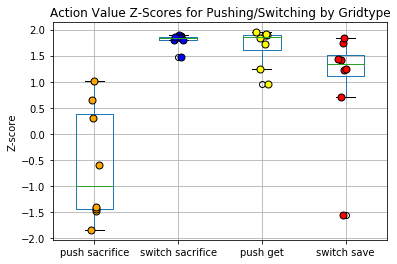

In [36]:
action_dict_1 = {101:(-1,0), 102:(0,-1), 103:(-1,0), 104:(0,-1), 105:(0,1), 106:(1,0), 107:(1,0), 108:(0,1)}
values_dict_1 = {101:[-1.1767265, -1.0324174, -1.8835071, -0.86973596, -0.77536863],102:[-1.3538408, -1.0442252, -1.3247898, -1.1993561, -1.5361774],103:[-1.2941076, -1.7552915, -1.4761472, -0.7999956, -0.9723728],104:[-1.0860451, -1.0470603,  -1.3127419,  -0.9341521,  -0.98842144], 105:[-1.6644025, -1.5616456, -1.4565037, -1.5372624, -1.971941], 106:[-1.6124309, -1.2362577, -1.7054666, -1.659347,  -1.576734 ], 107:[-0.70674944, -0.6101792,  -0.8176972,  -1.2862964,  -0.5073991], 108:[-1.1479484, -0.5938518, -1.404715, -0.9614413, -1.0457811]}
action_dict_2 = {201:(1,0), 202:(1,0), 203:(1,0), 204:(0,-1), 205:(-1,0), 206:(-1,0), 207:(0,-1), 208:(0,-1)}
values_dict_2 = {201:[-1.6788757, -1.9185416, -1.6891036, -1.1662648, -1.7030098],202:[-1.8375171, -1.9226363, -2.180282, -1.0223149, -2.1541476],203:[-2.1116846, -2.2182734, -2.4099617, -1.526751, -2.422653], 204:[-1.7597078, -1.6480842, -1.9755846, -1.7900858, -1.1802578], 205:[-1.7517802, -1.1867526, -1.941156, -1.6661398, -2.027573], 206:[-1.3082641, -1.0965493, -1.6737093, -1.3442647, -1.4538274]
, 207:[-1.8601956, -2.0635347, -2.082423, -2.198652, -1.4811413], 208:[-1.2898204, -1.5333438, -1.4816161, -1.2261819, -0.6694631]}
action_dict_3 = {301:(1,0), 302:(0,1), 303:(0,-1), 304:(-1,0), 305:(-1,0), 306:(0,1), 307:(0,1), 308:(-1,0)}
values_dict_3 = {301:[-0.7553139, -0.86162144, -0.6734041, -0.25232098, -1.0630145], 302:[-0.4246473, -0.33210558, -0.24380258, -0.6260917,  -0.3777626], 303:[-0.5099915, -0.5529005, -1.0464728, -0.46765953, -0.22530209], 304:[-0.81823516, -0.3685327, -1.1069403, -0.9968637, -1.1369932], 305:[-0.8567063, -0.9432911, -0.7837349, -0.8532402, -0.7421404], 306:[-0.46319106, -0.42678055, -0.2744125, -0.62645334, -0.38882115], 307:[-0.57995236, -0.6510018, -0.49551213, -0.41963458, -0.6570419], 308:[-0.7938474, -0.57117325, -1.1571733, -0.79256797,-0.9092601]
}
action_dict_4 = {401:(0,1), 402:(0,1), 403:(-1,0), 404:(0,1), 405:(-1,0), 406:(0,-1), 407:(1,0), 408:(0,1)}
values_dict_4 = {401:[-0.01652398, 0.01013105, 0.04654612, 0.04072732, -0.01685886], 402:[ 0.01748005, 0.04793983, 0.87550825, 0.29035276, -0.00939153], 403:[ 0.14397064, 0.89678633, 0.06764743, -0.04178202, -0.22374357], 404:[-0.04296061, 0.15611641, 0.14211813, 0.06048304,  0.05546034], 405:[0.02280764, 0.13023512, 0.03637661, 0.0611462, 0.06073915], 406:[0.09271584, -0.07913132, 0.00249178, 0.00111401, 0.60163736], 407:[0.06147841, -0.0448618, 0.0143538, 0.5324431, -0.12618832], 408:[0.1064885, 0.45419466, 0.7620585, 0.12373656, 0.24326058]
}


action_indexes = [(0, 0), (-1, 0), (0, 1), (1, 0), (0, -1)]

def get_qvalue_statistics(action_dict,values_dict):
    min_count = 0 
    max_count = 0
    z_scores = []
    for grid, action in action_dict.items():
        ind = action_indexes.index(action)
        if max(values_dict[grid]) == values_dict[grid][ind]:
            max_count += 1
        if min(values_dict[grid]) == values_dict[grid][ind]:
            min_count += 1
        z_scores.append((values_dict[grid][ind] - np.mean(values_dict[grid]))/np.std(values_dict[grid]))
    return z_scores

import pandas as pd
data = pd.DataFrame({
    "push sacrifice": get_qvalue_statistics(action_dict_1,values_dict_1),
    "switch sacrifice": get_qvalue_statistics(action_dict_2,values_dict_2), 
    "push get": get_qvalue_statistics(action_dict_4,values_dict_4),
    "switch save": get_qvalue_statistics(action_dict_3,values_dict_3)
    })


data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["orange","blue","yellow","red"][i], mec='k', ms=7, marker="o", linestyle="None")

plt.ylabel("Z-score")
plt.title("Action Value Z-Scores for Pushing/Switching by Gridtype")

In [247]:
from scipy.special import softmax
vals = np.array([-1.1767265, -1.0324174, -1.8835071, -0.86973596, -0.77536863])
m = softmax(vals)
print(m)

[0.18176363 0.20998083 0.08965119 0.24707642 0.27152793]
